# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    
    concatenate_layer = layers.concatenate([upsampled_layer,  large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    
    output_layer_1 = separable_conv2d_batchnorm(concatenate_layer, filters)
    
    return output_layer_1

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.

    encoder_layer_1 = encoder_block(inputs, 32, strides=2)
    encoder_layer_2 = encoder_block(encoder_layer_1, 64, strides=2)
    
    encoder_layer_3 = encoder_block(encoder_layer_2, 128, strides=2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    
    #Conv_1_by_1_layer = conv2d_batchnorm(encoder_layer_2, 128, kernel_size=1, strides=1)
    
    Conv_1_by_1_layer = conv2d_batchnorm(encoder_layer_3, 256, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    
    #decoder_layer_1 = decoder_block(Conv_1_by_1_layer, encoder_layer_1, 64)
    #decoder_layer_2 = decoder_block(decoder_layer_1, inputs, 32)
    
    decoder_layer_1 = decoder_block(Conv_1_by_1_layer, encoder_layer_2, 128)
    decoder_layer_2 = decoder_block(decoder_layer_1, encoder_layer_1, 64)
    decoder_layer_3 = decoder_block(decoder_layer_2, inputs, 32)
    
    x = decoder_layer_3
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [ ]:
training_images_size = 4131 
validation_images_size = 1184

learning_rate = 0.002
batch_size = 50
num_epochs = 100
#steps_per_epoch = 50
#validation_steps = 50
steps_per_epoch = training_images_size // batch_size + 1
validation_steps = validation_images_size // batch_size + 1
workers = 4

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 160, 3)   0                                            
____________________________________________________________________________________________________
separable_conv2d_keras_1 (Separa (None, 80, 80, 32)    155         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 80, 80, 32)    128         separable_conv2d_keras_1[0][0]   
____________________________________________________________________________________________________
separable_conv2d_keras_2 (Separa (None, 40, 40, 64)    2400        batch_normalization_1[0][0]      
___________________________________________________________________________________________

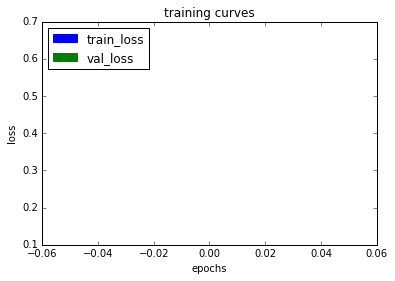

83/83 [==============================] - 49s - loss: 0.6341 - val_loss: 0.1862
Epoch 2/100
82/83 [============================>.] - ETA: 0s - loss: 0.0966

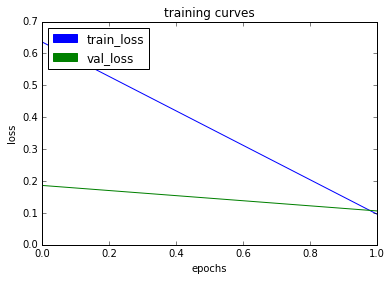

83/83 [==============================] - 49s - loss: 0.0962 - val_loss: 0.1063
Epoch 3/100
82/83 [============================>.] - ETA: 0s - loss: 0.0522

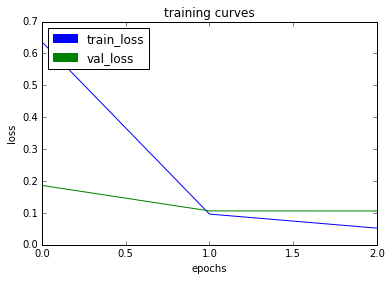

83/83 [==============================] - 47s - loss: 0.0523 - val_loss: 0.1061
Epoch 4/100
82/83 [============================>.] - ETA: 0s - loss: 0.0425

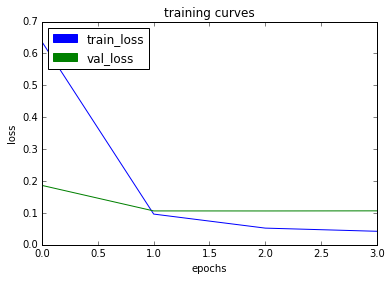

83/83 [==============================] - 49s - loss: 0.0424 - val_loss: 0.1065
Epoch 5/100
82/83 [============================>.] - ETA: 0s - loss: 0.0379

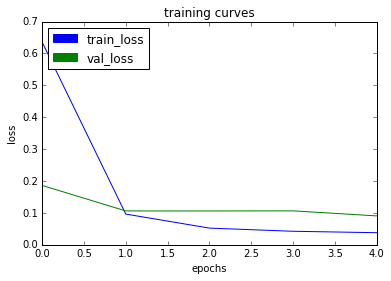

83/83 [==============================] - 48s - loss: 0.0380 - val_loss: 0.0906
Epoch 6/100
82/83 [============================>.] - ETA: 0s - loss: 0.0345

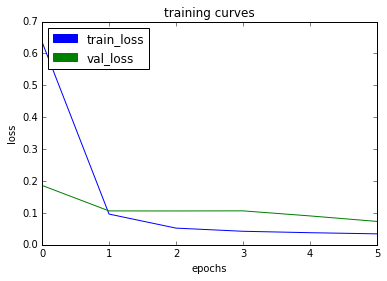

83/83 [==============================] - 49s - loss: 0.0345 - val_loss: 0.0734
Epoch 7/100
82/83 [============================>.] - ETA: 0s - loss: 0.0316

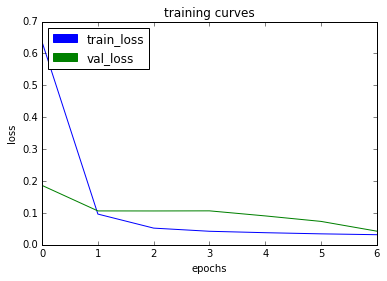

83/83 [==============================] - 48s - loss: 0.0317 - val_loss: 0.0427
Epoch 8/100
82/83 [============================>.] - ETA: 0s - loss: 0.0304

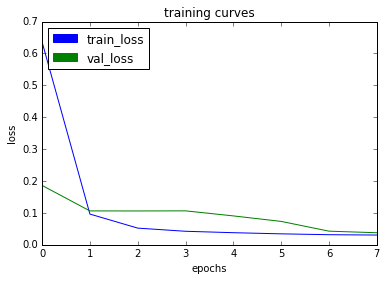

83/83 [==============================] - 50s - loss: 0.0306 - val_loss: 0.0378
Epoch 9/100
82/83 [============================>.] - ETA: 0s - loss: 0.0286

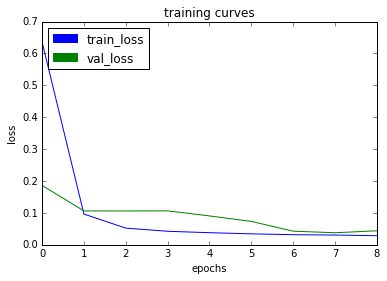

83/83 [==============================] - 48s - loss: 0.0285 - val_loss: 0.0439
Epoch 10/100
82/83 [============================>.] - ETA: 0s - loss: 0.0273

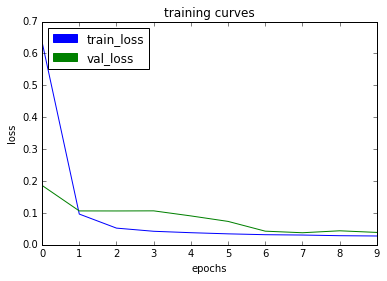

83/83 [==============================] - 50s - loss: 0.0276 - val_loss: 0.0388
Epoch 11/100
82/83 [============================>.] - ETA: 0s - loss: 0.0272

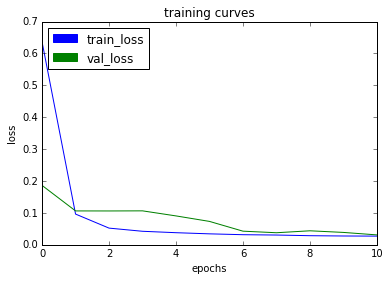

83/83 [==============================] - 47s - loss: 0.0272 - val_loss: 0.0311
Epoch 12/100
82/83 [============================>.] - ETA: 0s - loss: 0.0259

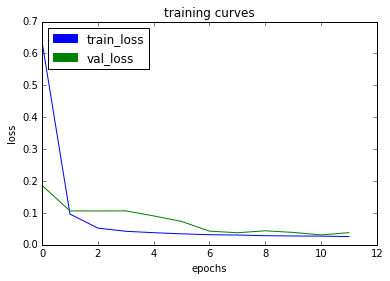

83/83 [==============================] - 48s - loss: 0.0259 - val_loss: 0.0380
Epoch 13/100
82/83 [============================>.] - ETA: 0s - loss: 0.0257

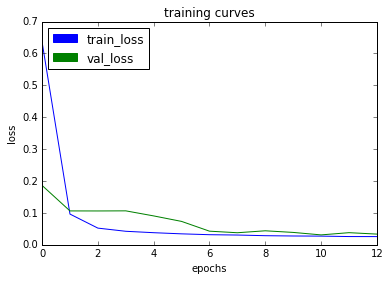

83/83 [==============================] - 47s - loss: 0.0258 - val_loss: 0.0336
Epoch 14/100
82/83 [============================>.] - ETA: 0s - loss: 0.0247

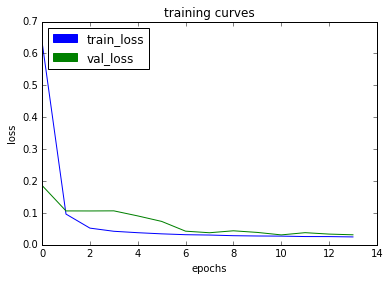

83/83 [==============================] - 47s - loss: 0.0247 - val_loss: 0.0314
Epoch 15/100
82/83 [============================>.] - ETA: 0s - loss: 0.0234

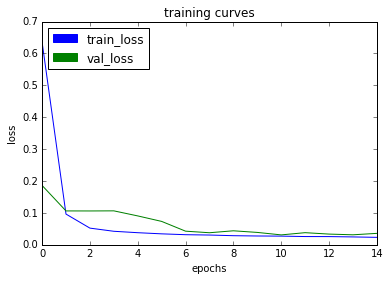

83/83 [==============================] - 49s - loss: 0.0233 - val_loss: 0.0359
Epoch 16/100
82/83 [============================>.] - ETA: 0s - loss: 0.0240

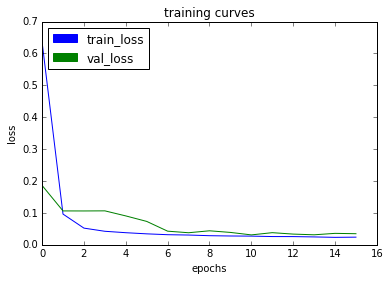

83/83 [==============================] - 46s - loss: 0.0240 - val_loss: 0.0348
Epoch 17/100
82/83 [============================>.] - ETA: 0s - loss: 0.0231

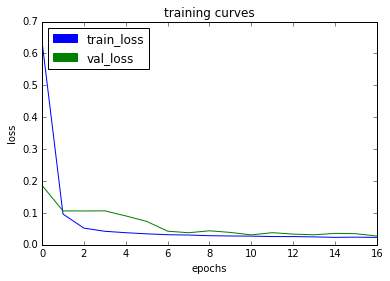

83/83 [==============================] - 48s - loss: 0.0231 - val_loss: 0.0274
Epoch 18/100
82/83 [============================>.] - ETA: 0s - loss: 0.0224

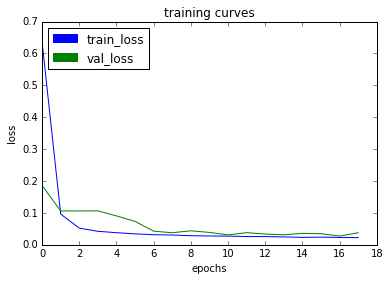

83/83 [==============================] - 47s - loss: 0.0224 - val_loss: 0.0379
Epoch 19/100
82/83 [============================>.] - ETA: 0s - loss: 0.0214

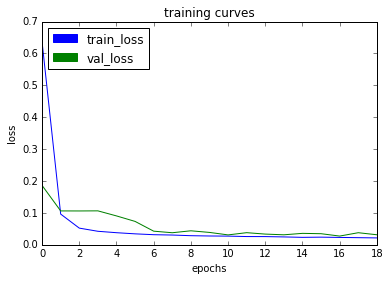

83/83 [==============================] - 47s - loss: 0.0216 - val_loss: 0.0315
Epoch 20/100
82/83 [============================>.] - ETA: 0s - loss: 0.0234

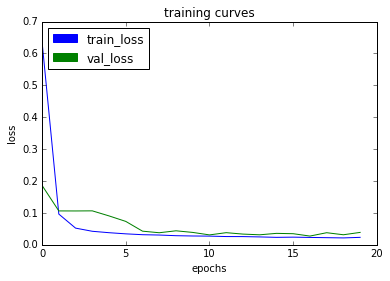

83/83 [==============================] - 49s - loss: 0.0234 - val_loss: 0.0389
Epoch 21/100
82/83 [============================>.] - ETA: 0s - loss: 0.0208

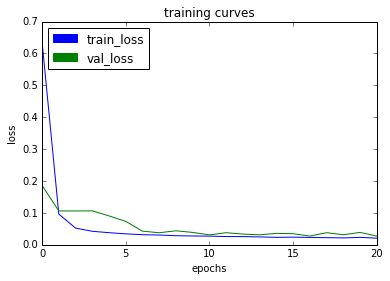

83/83 [==============================] - 47s - loss: 0.0207 - val_loss: 0.0272
Epoch 22/100
82/83 [============================>.] - ETA: 0s - loss: 0.0199

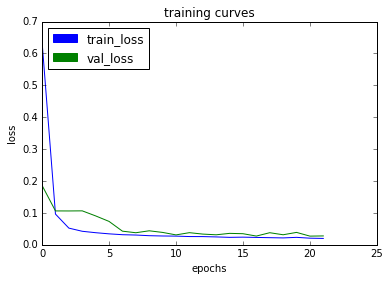

83/83 [==============================] - 48s - loss: 0.0200 - val_loss: 0.0278
Epoch 23/100
82/83 [============================>.] - ETA: 0s - loss: 0.0204

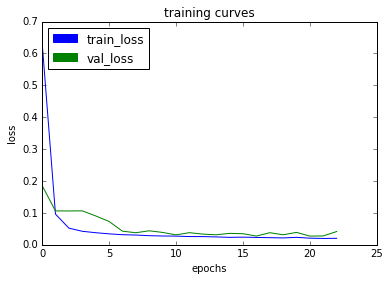

83/83 [==============================] - 47s - loss: 0.0203 - val_loss: 0.0417
Epoch 24/100
82/83 [============================>.] - ETA: 0s - loss: 0.0197

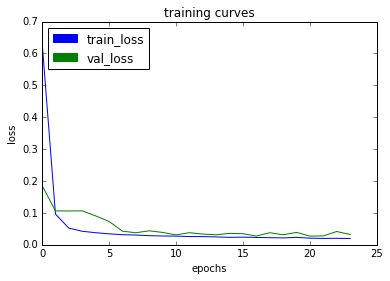

83/83 [==============================] - 49s - loss: 0.0197 - val_loss: 0.0324
Epoch 25/100
82/83 [============================>.] - ETA: 0s - loss: 0.0203

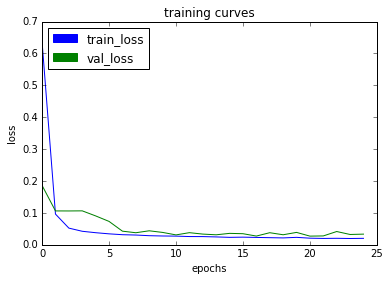

83/83 [==============================] - 48s - loss: 0.0203 - val_loss: 0.0335
Epoch 26/100
82/83 [============================>.] - ETA: 0s - loss: 0.0198

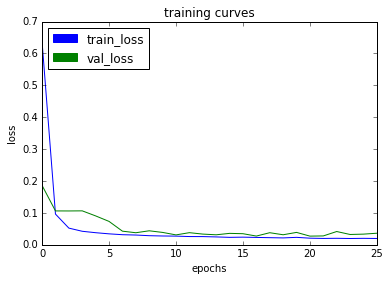

83/83 [==============================] - 48s - loss: 0.0198 - val_loss: 0.0363
Epoch 27/100
82/83 [============================>.] - ETA: 0s - loss: 0.0185

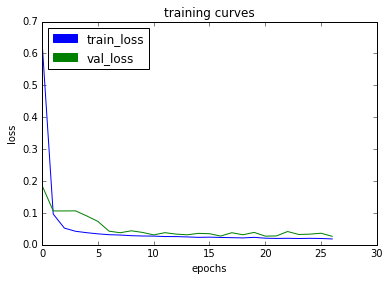

83/83 [==============================] - 48s - loss: 0.0184 - val_loss: 0.0265
Epoch 28/100
82/83 [============================>.] - ETA: 0s - loss: 0.0185

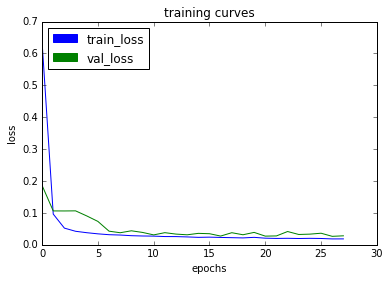

83/83 [==============================] - 49s - loss: 0.0185 - val_loss: 0.0282
Epoch 29/100
82/83 [============================>.] - ETA: 0s - loss: 0.0185

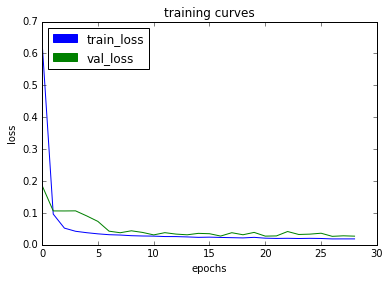

83/83 [==============================] - 48s - loss: 0.0185 - val_loss: 0.0271
Epoch 30/100
82/83 [============================>.] - ETA: 0s - loss: 0.0182

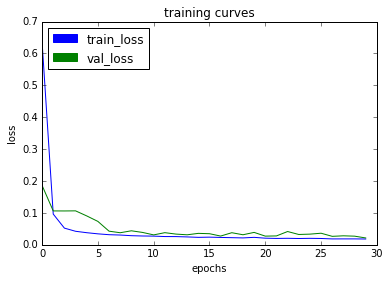

83/83 [==============================] - 48s - loss: 0.0182 - val_loss: 0.0215
Epoch 31/100
82/83 [============================>.] - ETA: 0s - loss: 0.0175

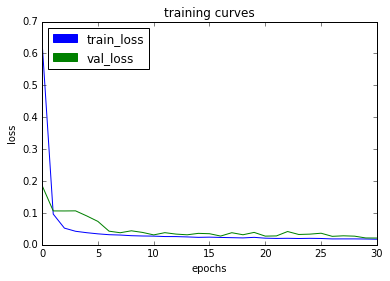

83/83 [==============================] - 48s - loss: 0.0175 - val_loss: 0.0212
Epoch 32/100
82/83 [============================>.] - ETA: 0s - loss: 0.0164

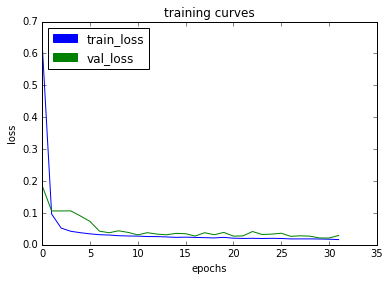

83/83 [==============================] - 51s - loss: 0.0164 - val_loss: 0.0292
Epoch 33/100
82/83 [============================>.] - ETA: 0s - loss: 0.0165

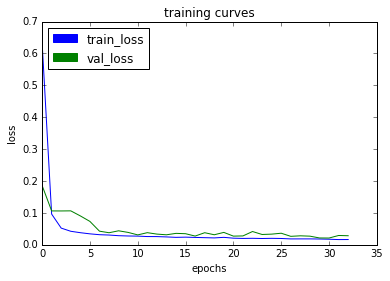

83/83 [==============================] - 50s - loss: 0.0165 - val_loss: 0.0284
Epoch 34/100
82/83 [============================>.] - ETA: 0s - loss: 0.0174

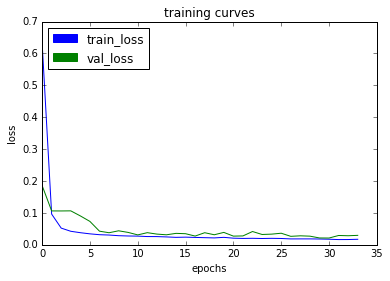

83/83 [==============================] - 49s - loss: 0.0173 - val_loss: 0.0296
Epoch 35/100
82/83 [============================>.] - ETA: 0s - loss: 0.0154

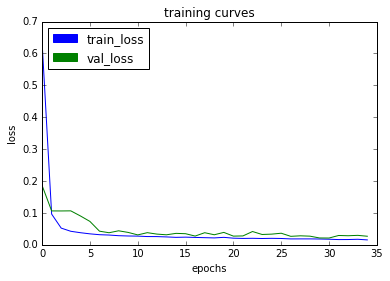

83/83 [==============================] - 50s - loss: 0.0154 - val_loss: 0.0268
Epoch 36/100
82/83 [============================>.] - ETA: 0s - loss: 0.0199

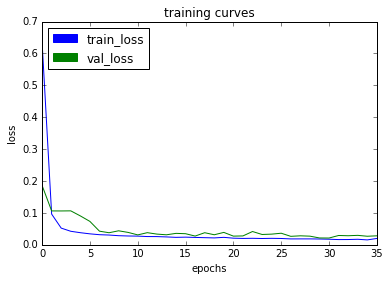

83/83 [==============================] - 48s - loss: 0.0199 - val_loss: 0.0282
Epoch 37/100
82/83 [============================>.] - ETA: 0s - loss: 0.0170

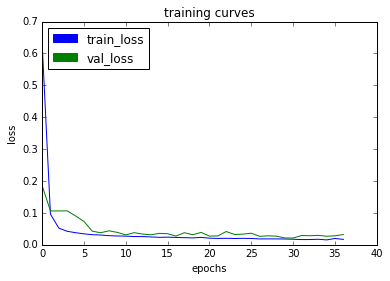

83/83 [==============================] - 49s - loss: 0.0169 - val_loss: 0.0322
Epoch 38/100
82/83 [============================>.] - ETA: 0s - loss: 0.0164

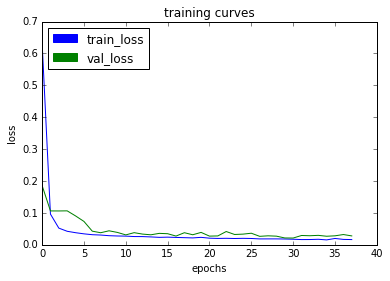

83/83 [==============================] - 49s - loss: 0.0164 - val_loss: 0.0279
Epoch 39/100
82/83 [============================>.] - ETA: 0s - loss: 0.0155

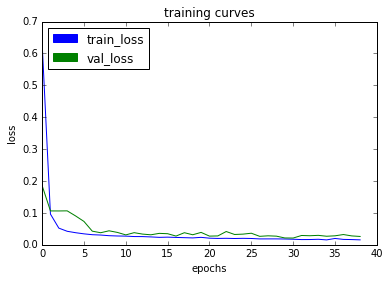

83/83 [==============================] - 50s - loss: 0.0155 - val_loss: 0.0262
Epoch 40/100
82/83 [============================>.] - ETA: 0s - loss: 0.0163

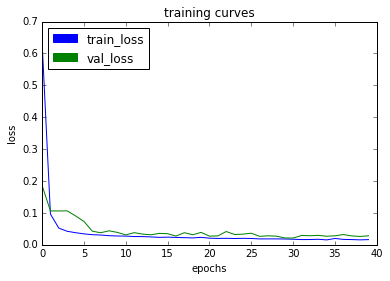

83/83 [==============================] - 47s - loss: 0.0162 - val_loss: 0.0283
Epoch 41/100
82/83 [============================>.] - ETA: 0s - loss: 0.0165

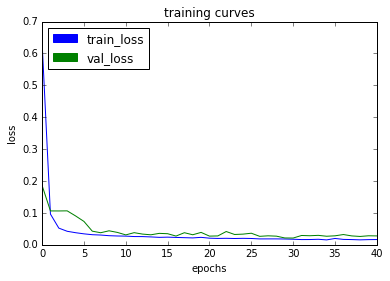

83/83 [==============================] - 49s - loss: 0.0165 - val_loss: 0.0279
Epoch 42/100
82/83 [============================>.] - ETA: 0s - loss: 0.0159

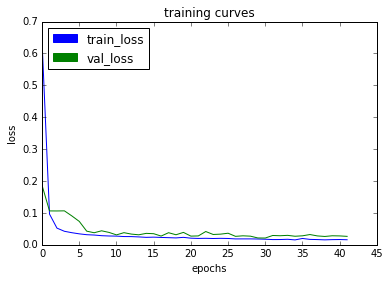

83/83 [==============================] - 47s - loss: 0.0158 - val_loss: 0.0265
Epoch 43/100
82/83 [============================>.] - ETA: 0s - loss: 0.0150

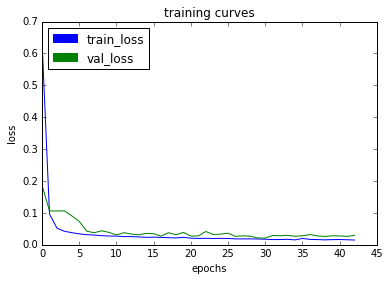

83/83 [==============================] - 48s - loss: 0.0149 - val_loss: 0.0293
Epoch 44/100
82/83 [============================>.] - ETA: 0s - loss: 0.0148

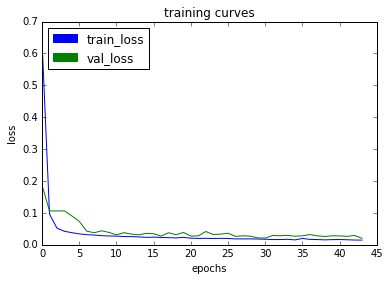

83/83 [==============================] - 47s - loss: 0.0148 - val_loss: 0.0205
Epoch 45/100
82/83 [============================>.] - ETA: 0s - loss: 0.0175

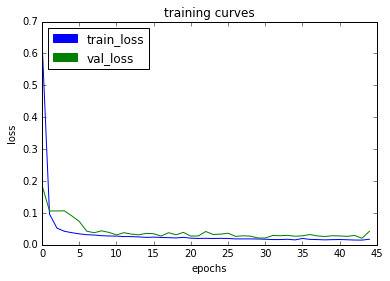

83/83 [==============================] - 47s - loss: 0.0174 - val_loss: 0.0424
Epoch 46/100
82/83 [============================>.] - ETA: 0s - loss: 0.0164

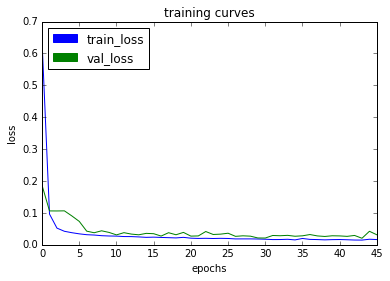

83/83 [==============================] - 48s - loss: 0.0164 - val_loss: 0.0314
Epoch 47/100
82/83 [============================>.] - ETA: 0s - loss: 0.0166

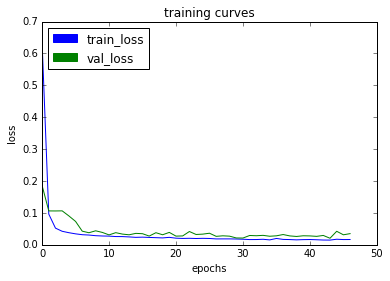

83/83 [==============================] - 47s - loss: 0.0166 - val_loss: 0.0350
Epoch 48/100
82/83 [============================>.] - ETA: 0s - loss: 0.0170

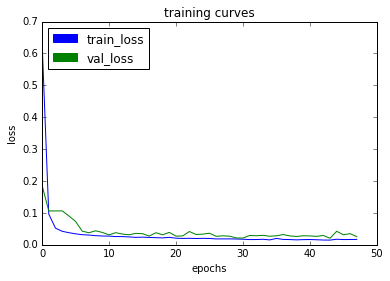

83/83 [==============================] - 49s - loss: 0.0170 - val_loss: 0.0255
Epoch 49/100
82/83 [============================>.] - ETA: 0s - loss: 0.0147

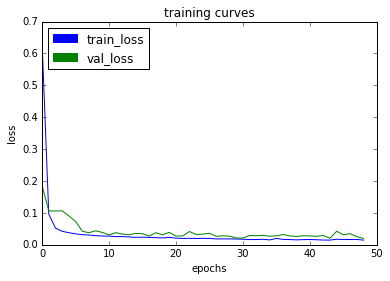

83/83 [==============================] - 47s - loss: 0.0147 - val_loss: 0.0201
Epoch 50/100
82/83 [============================>.] - ETA: 0s - loss: 0.0143

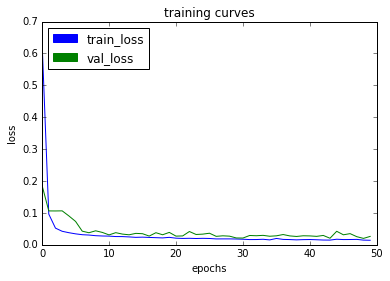

83/83 [==============================] - 49s - loss: 0.0143 - val_loss: 0.0263
Epoch 51/100
82/83 [============================>.] - ETA: 0s - loss: 0.0144

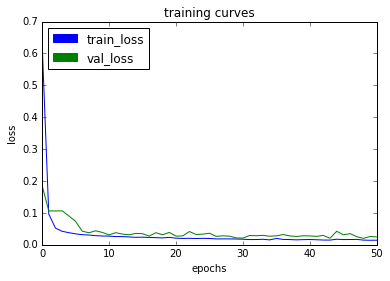

83/83 [==============================] - 47s - loss: 0.0144 - val_loss: 0.0245
Epoch 52/100
82/83 [============================>.] - ETA: 0s - loss: 0.0140

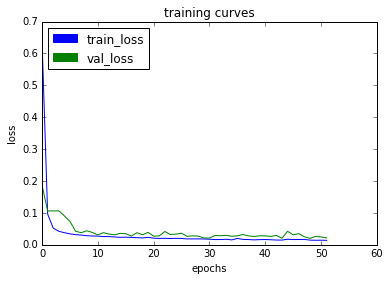

83/83 [==============================] - 47s - loss: 0.0139 - val_loss: 0.0218
Epoch 53/100
82/83 [============================>.] - ETA: 0s - loss: 0.0132

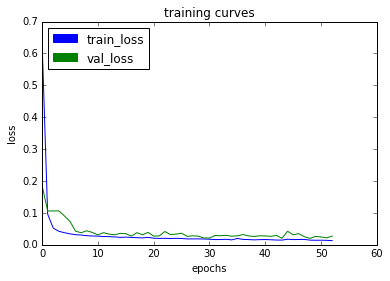

83/83 [==============================] - 50s - loss: 0.0132 - val_loss: 0.0274
Epoch 54/100
82/83 [============================>.] - ETA: 0s - loss: 0.0130

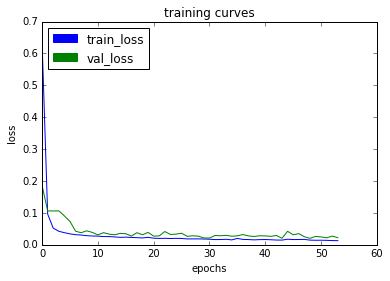

83/83 [==============================] - 48s - loss: 0.0130 - val_loss: 0.0223
Epoch 55/100
82/83 [============================>.] - ETA: 0s - loss: 0.0143

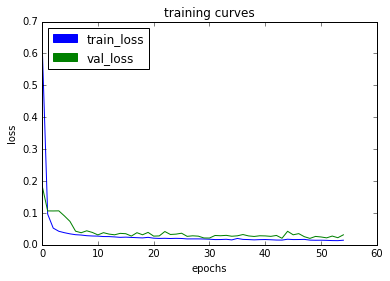

83/83 [==============================] - 49s - loss: 0.0144 - val_loss: 0.0313
Epoch 56/100
82/83 [============================>.] - ETA: 0s - loss: 0.0159

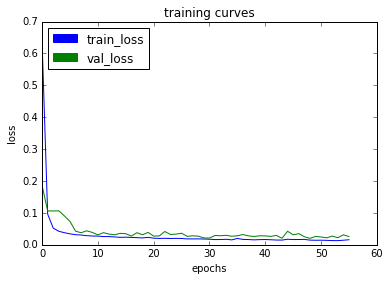

83/83 [==============================] - 47s - loss: 0.0159 - val_loss: 0.0259
Epoch 57/100
82/83 [============================>.] - ETA: 0s - loss: 0.0131

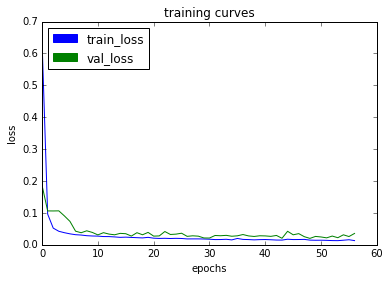

83/83 [==============================] - 48s - loss: 0.0132 - val_loss: 0.0356
Epoch 58/100
82/83 [============================>.] - ETA: 0s - loss: 0.0156

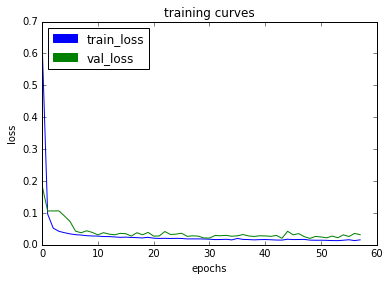

83/83 [==============================] - 48s - loss: 0.0156 - val_loss: 0.0318
Epoch 59/100
82/83 [============================>.] - ETA: 0s - loss: 0.0145

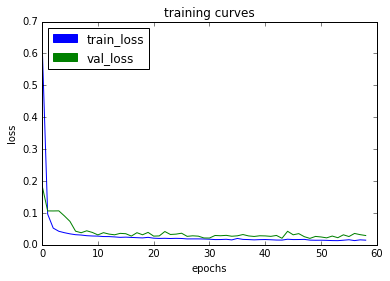

83/83 [==============================] - 48s - loss: 0.0145 - val_loss: 0.0291
Epoch 60/100
82/83 [============================>.] - ETA: 0s - loss: 0.0139

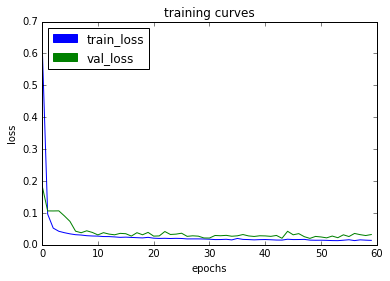

83/83 [==============================] - 48s - loss: 0.0139 - val_loss: 0.0321
Epoch 61/100
82/83 [============================>.] - ETA: 0s - loss: 0.0128

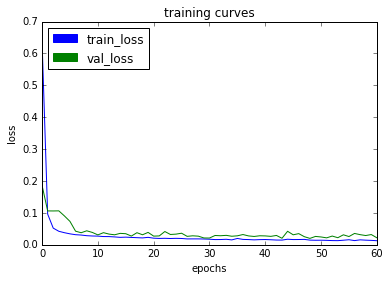

83/83 [==============================] - 47s - loss: 0.0128 - val_loss: 0.0220
Epoch 62/100
82/83 [============================>.] - ETA: 0s - loss: 0.0127

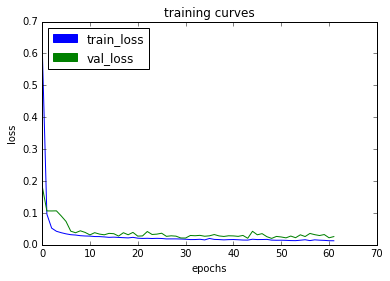

83/83 [==============================] - 49s - loss: 0.0127 - val_loss: 0.0258
Epoch 63/100
82/83 [============================>.] - ETA: 0s - loss: 0.0120

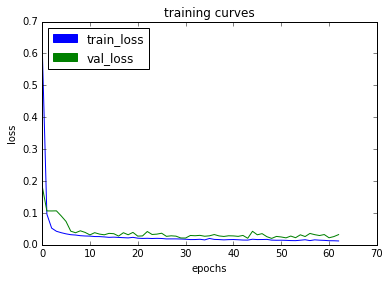

83/83 [==============================] - 47s - loss: 0.0121 - val_loss: 0.0320
Epoch 64/100
82/83 [============================>.] - ETA: 0s - loss: 0.0150

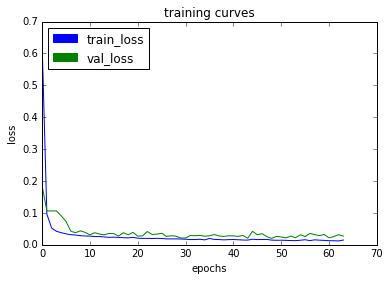

83/83 [==============================] - 49s - loss: 0.0150 - val_loss: 0.0271
Epoch 65/100
82/83 [============================>.] - ETA: 0s - loss: 0.0127

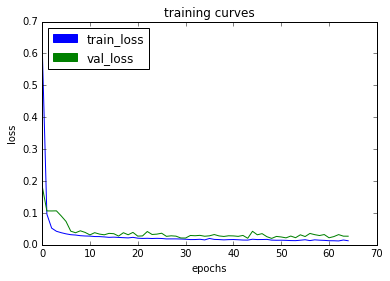

83/83 [==============================] - 47s - loss: 0.0127 - val_loss: 0.0270
Epoch 66/100
82/83 [============================>.] - ETA: 0s - loss: 0.0129

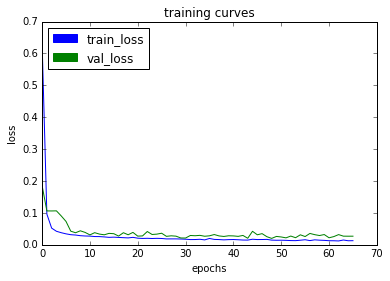

83/83 [==============================] - 49s - loss: 0.0129 - val_loss: 0.0270
Epoch 67/100
82/83 [============================>.] - ETA: 0s - loss: 0.0128

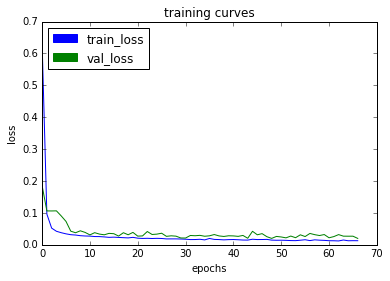

83/83 [==============================] - 48s - loss: 0.0128 - val_loss: 0.0200
Epoch 68/100
82/83 [============================>.] - ETA: 0s - loss: 0.0121

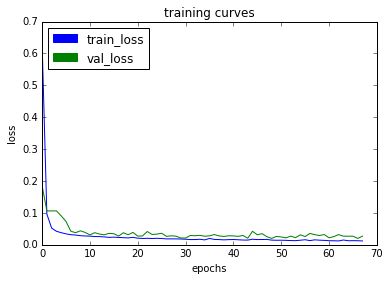

83/83 [==============================] - 49s - loss: 0.0121 - val_loss: 0.0272
Epoch 69/100
82/83 [============================>.] - ETA: 0s - loss: 0.0117

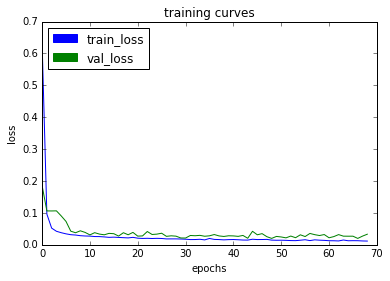

83/83 [==============================] - 46s - loss: 0.0117 - val_loss: 0.0332
Epoch 70/100
42/83 [==============>...............] - ETA: 22s - loss: 0.0113

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [ ]:
run_num = 'run_7'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

In [ ]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

In [ ]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

In [ ]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [ ]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

In [ ]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

In [ ]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

In [ ]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

In [ ]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

In [ ]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)